# Task3 GROUND-OBJECT CLASSIFICATION 


### 本任务的目的是通过KAGGLE遥感数据集的训练熟悉基于Deeplabv3+网络语义分割流程。
1. 学习深度学习模型库的调用
2. 学习遥感数据切片方案
3. 学习Deeplabv3+网络
4. 学习精度评价方法

In [1]:
import pandas as pd
import numpy as np
import os
import time
import random
import matplotlib.pyplot as plt
from keras.models import Model
from keras.layers import Input, Concatenate, Conv2D, MaxPooling2D, UpSampling2D, Dropout,BatchNormalization,ZeroPadding2D,add, Flatten,Activation,AveragePooling2D,Dense
from keras.optimizers import Adam,Adamax,Nadam,Adadelta,SGD,RMSprop
from keras.callbacks import ModelCheckpoint, LearningRateScheduler,CSVLogger
from keras.layers.core import Lambda
from keras.preprocessing.image import img_to_array
from keras import backend as K
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, roc_curve, auc
import h5py
import gdal
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
import cv2
from PIL import Image
from allmodel import all_model
from historycal import LossHistory

Using TensorFlow backend.
D:\Anaconda3\envs\Keras\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\Anaconda3\envs\Keras\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\Anaconda3\envs\Keras\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\Anaconda3\envs\Keras\lib\site-packages\tensorflow\python\framework\dtypes.py:526

# patches producing

In [2]:
def regular_crop(imagearray, crop_sz,step=256):
    data_all = []
    for i in np.arange(1):
        data = []
        x=0
#         src_img_row,src_img_col=(imagearray.size)[0:2]
        row_num = ((imagearray.shape)[0] - step) // step  ###最多能裁剪几行 几列
        col_num=((imagearray.shape)[1] - step) // step
    #print(row_num,col_num)
        x_start=0
        y_start=0
        for h in range(row_num):
            for w in range(col_num):
                crop_img = imagearray[crop_sz*h+y_start:crop_sz*(h+1)+y_start, crop_sz*w+x_start:crop_sz*(w+1)+x_start,:]               
#                 crop_img= imagearray.crop((step * h, step * w,step * h + crop_sz,step * w + crop_sz))
                data.append(crop_img)
                x=x+1
                # if x % 10 ==0:
                    # print("processing....patch:"+str(i)+"...No.:"+str(x))
                    
        data=np.array(data)
        # print("processing....patch:"+str(i)+"..Total.No.:"+str(data.shape))
        if i == 0:
            data_all = data
        else:
            data_all=np.concatenate((data_all, data), axis = 0)
    return data_all
def label_hot(label,n_label=1):
    listlabel=[]
    for i in label:
        mask=i.flatten()
        mask=to_categorical(mask, num_classes=n_label)
        listlabel.append(mask)
    msk=np.asarray(listlabel,dtype='uint16')
    msk=msk.reshape((label.shape[0],label.shape[1],label.shape[2],n_label))
#     print(msk.shape)
    return msk
 
def changelabel(arr,a):
    arr=np.array(arr)
    new=arr*0
    new[np.where(arr==a)]=1
    return new
def get_normalized_patches(data,value,n_label=1):
    img = data[:,:,:,0:3]/value
    msk = data[:,:,:,-1]
    # msk = changelabel(msk,4)
    msk = label_hot(msk,n_label)
    # msk = np.expand_dims(msk,axis=3)
    return img,msk
def post_normalize_image(img,value):
    return img/value
def patches_generator(allimage,crop_sz):
    allarray=[]
    for index, value in enumerate(allimage):
        # print(value.shape)
        singlearr=regular_crop(value,crop_sz)
    # allarray.append(array)
        if index == 0:
            allarray = singlearr
            # print(allarray.shape,singlearr.shape)
        else:
            allarray=np.concatenate((allarray, singlearr), axis = 0)
            # print(allarray.shape)
    print(allarray.shape)
    return(allarray)
def plot_func(data,label,key):
    fig=plt.figure(figsize=(25,5))
    for i in range(16):
        plt.subplot(2,8,i+1)
        plt.imshow(Image.fromarray(np.uint8((data[i,:,:,:3])*255)))
    plt.show()
    fig=plt.figure(figsize=(25,5))
    for i in range(16):
        plt.subplot(2,8,i+1)
        plt.imshow((label[i,:,:,key]),cmap="gray")
    plt.show()
def val_plot_func(data,label,pred,key):
    fig=plt.figure(figsize=(25,5))
    for i in range(16):
        plt.subplot(2,8,i+1)
        plt.imshow(Image.fromarray(np.uint8((data[i,:,:,:3])*255)))
    plt.show()
    fig=plt.figure(figsize=(25,5))
    for i in range(16):
        plt.subplot(2,8,i+1)
        plt.imshow((label[i,:,:,key]),cmap="gray")
    plt.show()
    fig=plt.figure(figsize=(25,5))
    for i in range(16):
        plt.subplot(2,8,i+1)
        plt.imshow((pred[i,:,:,key]),cmap="gray")
    plt.show()

In [3]:
class1_hdf5_path ='Y:\\Deep learning teaching\\task3\\data\\kaggle_rgb_4b_6c.hdf5'
fd = h5py.File(class1_hdf5_path)
fd.keys()
data=fd['data']
label=fd['label']
label=changelabel(label,4)
# fd.close
print(data.shape,label.shape)
n_label=2

(15, 3840, 3840, 3) (15, 3840, 3840, 1)


In [4]:
allimage=np.concatenate((data,label),axis=3)
# print(allimage.shape)
allpatches=patches_generator(allimage[:-1],256)
images,labels=get_normalized_patches(allpatches,10000.0,n_label)
print(images.shape,labels.shape)
testimage=allimage[-1,:,:,:-1]
testlabel=allimage[-1,:,:,-1]
print(testimage.shape,testlabel.shape)

(2744, 256, 256, 4)
(2744, 256, 256, 3) (2744, 256, 256, 2)
(3840, 3840, 3) (3840, 3840)


(2195, 256, 256, 3) (549, 256, 256, 3) (2195, 256, 256, 2) (549, 256, 256, 2)


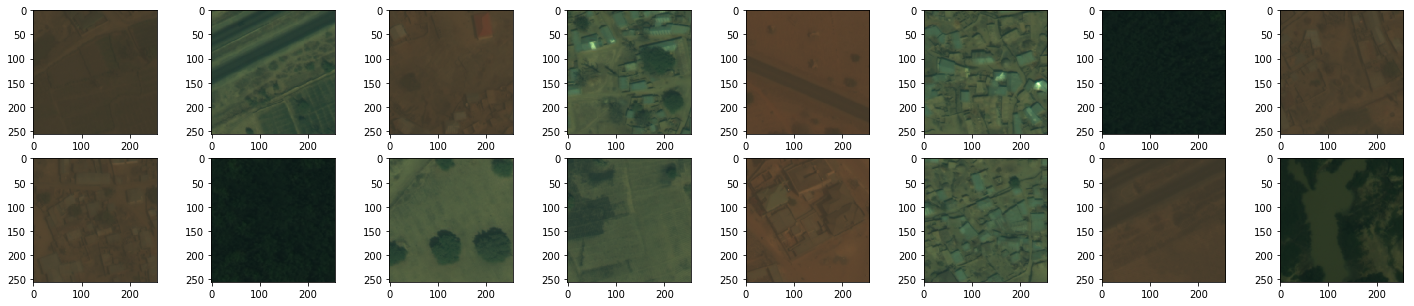

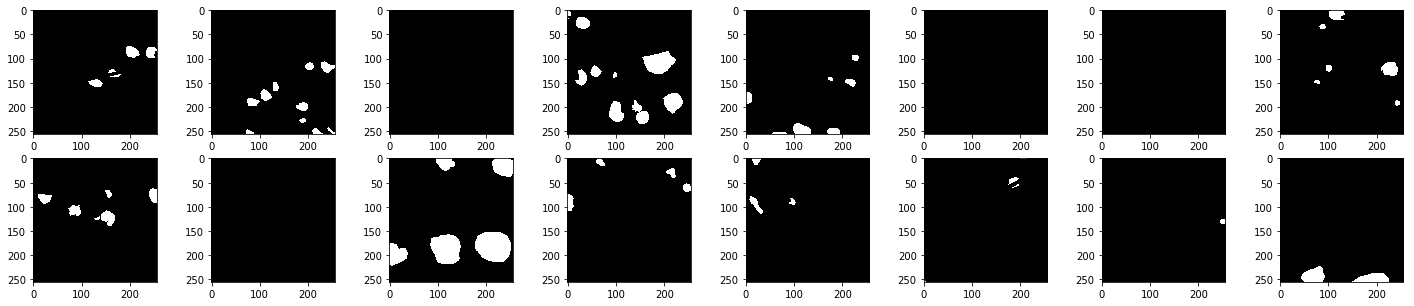

In [5]:
xtrain,xtest,ytrain,ytest=train_test_split(images,labels,test_size=0.2,random_state=42)
print(xtrain.shape,xtest.shape,ytrain.shape,ytest.shape)
plot_func(xtrain,ytrain,1)

# Model Training

In [6]:
loss='categorical_crossentropy'#'binary_crossentropy'
optimizer=Adam()#Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)#Adam()#SGD(),Adamax(),Adadelta()R
loss_weights=''
metrics=['accuracy']
input_height=256
input_width=256
batch_size=40
epoch=20
nclass=n_label
nchannel=xtrain.shape[-1]
num_train=xtrain.shape[0]
num_val=xtest.shape[0]
ATM=all_model(loss,loss_weights,optimizer,metrics,input_height,input_width,nclass,nchannel)
nickname='unet'


In [8]:
model=ATM.UNET_VGG()#FCN8,UNET_VGG,UNET_MINI,SQUEESE_UNET,DEEPLABV3plus
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_24 (Conv2D)              (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_25 (Conv2D)              (None, 256, 256, 32) 9248        conv2d_24[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_5 (MaxPooling2D)  (None, 128, 128, 32) 0           conv2d_25[0][0]                  
__________________________________________________________________________________________________
conv2d_26 

In [110]:
begin_time = time.time()           
model_checkpoint = ModelCheckpoint(filepath="./checkpoint\\"+nickname+"-{epoch:02d}e-val_loss{val_loss:2f}.hdf5",monitor="val_loss",save_best_only=True,mode='auto')
histories=LossHistory()
csvlogger =CSVLogger(filename="./checkpoint\\"+nickname+'-'+str(epoch)+'-log.csv', separator=',', append=False)
# result=model.fit(xtrain, ytrain, batch_size=batch_size, epochs=epoch, verbose=1, shuffle=True,validation_data=(xtest, ytest),callbacks=[model_checkpoint,CSVLogger])
result=model.fit(xtrain, ytrain, batch_size=batch_size, epochs=epoch, verbose=1, shuffle=True,validation_data=(xtest, ytest),callbacks=[model_checkpoint,histories,csvlogger])
end_time = time.time()
print('time lapsing {0} s \n'.format(end_time - begin_time))

Train on 2195 samples, validate on 549 samples
Epoch 1/20
2195/2195 [==============================] - 44s 20ms/step - loss: 0.2758 - acc: 0.9268 - val_loss: 0.2523 - val_acc: 0.9224
Epoch 2/20
2195/2195 [==============================] - 31s 14ms/step - loss: 0.2438 - acc: 0.9268 - val_loss: 0.2403 - val_acc: 0.9224
Epoch 3/20
2195/2195 [==============================] - 29s 13ms/step - loss: 0.2287 - acc: 0.9268 - val_loss: 0.2282 - val_acc: 0.9224
Epoch 4/20
2195/2195 [==============================] - 30s 14ms/step - loss: 0.2141 - acc: 0.9268 - val_loss: 0.2300 - val_acc: 0.9224
Epoch 5/20
2195/2195 [==============================] - 29s 13ms/step - loss: 0.2092 - acc: 0.9268 - val_loss: 0.1995 - val_acc: 0.9224
Epoch 6/20
2195/2195 [==============================] - 29s 13ms/step - loss: 0.2082 - acc: 0.9268 - val_loss: 0.1992 - val_acc: 0.9224
Epoch 7/20
2195/2195 [==============================] - 29s 13ms/step - loss: 0.1939 - acc: 0.9277 - val_loss: 0.1983 - val_acc: 0.9212
E

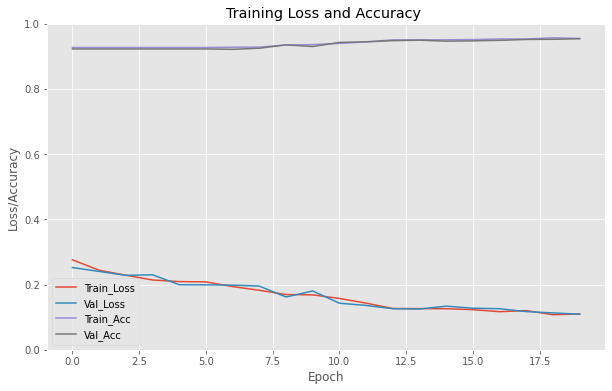

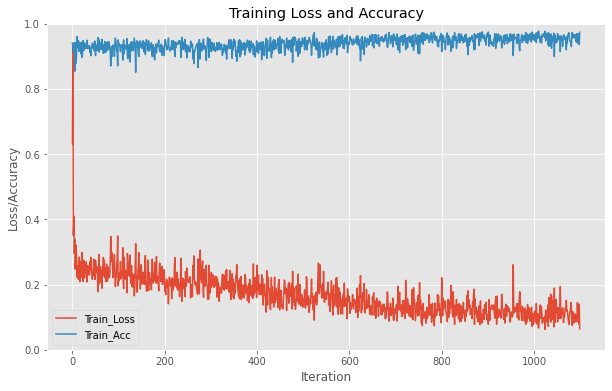

history already saved!


In [113]:
histories.loss_plot('epoch',nickname)
histories.loss_plot('batch',nickname)
h5_path ="./checkpoint\\"+nickname+"_train_history_"+str(epoch)+".h5"
histories.h5_save(h5_path)
print("history already saved!")

In [ ]:
i=0
pred=model.predict(xtest[:200],batch_size=20)

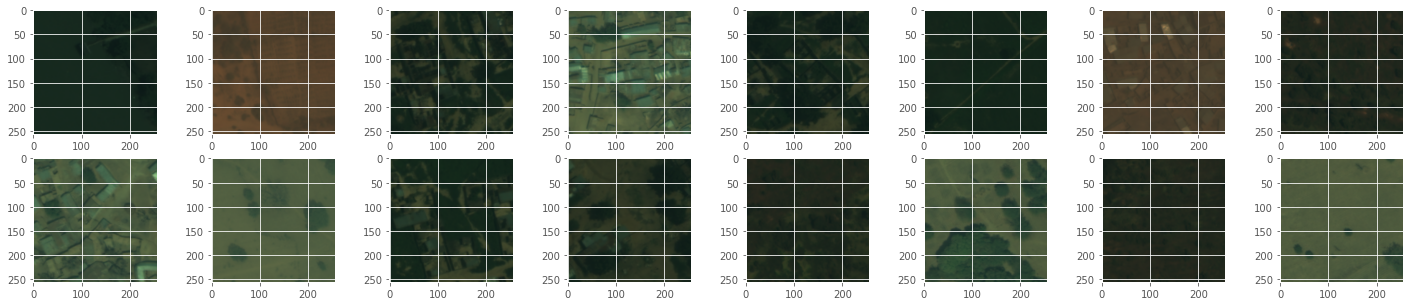

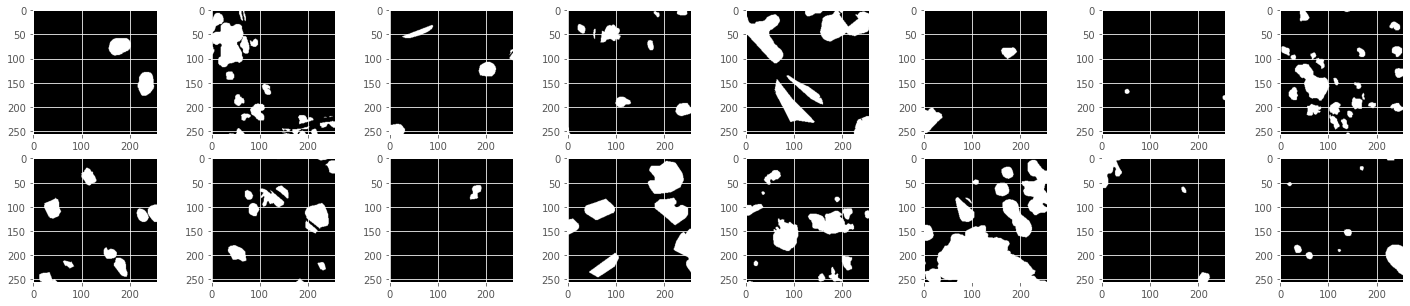

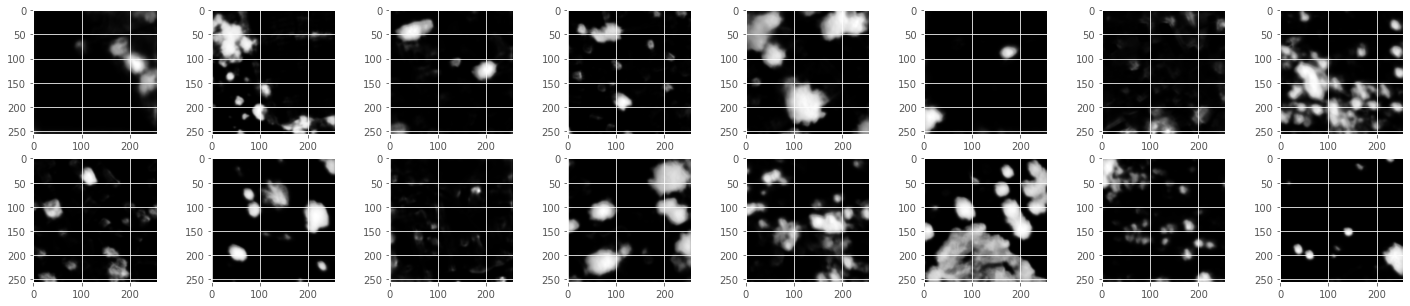

In [120]:
val_plot_func(xtest[i:i+20],ytest[i:i+20],pred[i:i+20],1)
i+=20

# Prediction

In [122]:
def predict(image,ProductDir,shotname,threshold,n_label,is_score=1):
    #print("[INFO] loading network...")
    stride=128   #128
    image_size=256
    h,w,c = image.shape
    padding_h = (h//stride + 1) * stride
    padding_w = (w//stride + 1) * stride
    padding_img = np.zeros((padding_h,padding_w,c),dtype=np.float32)
    padding_img[0:h,0:w,:] = image[:,:,:]
    padding_img = padding_img.astype("float")
    # padding_img = img_to_array(padding_img)
    # 	print ('src:',padding_img.shape)
    mask_whole = np.zeros((padding_h,padding_w,n_label),dtype=np.float32)
    print('all images='+str((padding_h//stride)*(padding_w//stride)))
    for i in range(padding_h//stride):
        if i % 10 ==0 :
            print('processing.....' +str(i)+'    of   '+str(padding_h//stride))
        for j in range(padding_w//stride):
            crop = padding_img[i*stride:i*stride+image_size,j*stride:j*stride+image_size,:]
            #         print(crop.shape)
            ch,cw,c = crop.shape
            if ch != image_size or cw != image_size:
            #             print ('invalid size!')
                continue
            crop = np.expand_dims(crop, axis=0)
            pred = model.predict(crop,verbose=0)
#             print(pred.shape)
            #pred=np.argmax(pred, axis=-1)
            #print (np.unique(pred))
            pred = pred.reshape((image_size,image_size,n_label)).astype(np.float32)
#             print(pred.shape)
            #print 'pred:',pred.shape
            mask_whole[i*stride:i*stride+image_size,j*stride:j*stride+image_size,:] = pred[:,:,:]
            #mask_whole[i * stride:i * stride + image_size , j * stride:j * stride + image_size,:] = pred[:,:,:]

    img_final = mask_whole[0:h, 0:w,:]
#    print(np.mean(img_final))
    imgarr=np.zeros((h,w),dtype=np.uint8)

#    if is_score==1:
#        for k in range(n_label):
#            im=np.array((img_final[:,:,i]*256),dtype=np.uint8)
#            imwrite((ProductDir+shotname+'_score'+str(k)+'.png'),im)
#            imgarr[img_final[:,:,i]>threshold]=1
#            imgarr[img_final[:,:,i]<=threshold]=0
#            im=np.array(imgarr*255,dtype=np.uint8)   
#            cv2.imwrite((ProductDir+shotname+'_pred'+str(k)+'.png'),im)

    #img_final[img_final>=1]=1
    pred=np.argmax(img_final, axis=-1)
    cv2.imwrite((ProductDir+shotname+'_prdlabels.png'),pred*255)
    #print (np.unique(img_final))
    return pred,img_final

def out_report(gt_arr,label_arr,out_csv):
    # gt_arr=Load_image_by_Gdal(gt)
    gt_reshape=gt_arr.reshape((gt_arr.shape[0]*gt_arr.shape[1],1))
    label_reshape=label_arr.reshape((label_arr.shape[0]*label_arr.shape[1],1))
    acc=classification_report(gt_reshape,label_reshape,output_dict=True)
    df=pd.DataFrame(acc).transpose()
    df.to_csv(out_csv,index=True)   

# Evaluation

In [132]:
PREDICTION_DIR = "./prediction\\"+nickname+'\\'
if not os.path.exists(PREDICTION_DIR):
    os.makedirs(PREDICTION_DIR)
msk_result,mask_arr=predict(testimage/10000.0,PREDICTION_DIR,nickname,0.5,n_label)
out_report(testlabel,msk_result,PREDICTION_DIR+'matrics.csv')